# Import data

In [2]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
ls drive/MyDrive/ML_project/bases_originales

carac_soc.csv  rel_pareja_1.csv  roles.csv
carac_viv.csv  rel_pareja_2.csv  toma_dec.csv


In [ ]:
rel_pareja_1 = pd.read_csv("drive/MyDrive/ML_project/bases_originales/rel_pareja_1.csv", dtype='string')
rel_pareja_2 = pd.read_csv("datos/rel_pareja_2.csv", dtype='string')
rel_tviv = pd.read_csv("datos/carac_viv.csv", dtype='string')
rel_roles = pd.read_csv("datos/roles.csv", dtype={'ID_VIV': 'string','ID_MUJ': 'string', 'DOMINIO': 'string', 'NOM_ENT': 'string',
                                                     'NOM_MUN': 'string', 'T_INSTRUM': 'string'})

rel_sdem = pd.read_csv("datos/carac_sociales.csv", dtype={'ID_VIV': 'string','ID_MUJ': 'string', 'NOM_ENT':'string', 'NOM_MUN': 'string', 
                                                'COD_RES_E': 'string', 'NOMBRE': 'string', 'NIV': 'string', 
                                                'GRA': 'string', 'P2_8': 'string', 'P2_9': 'string', 'P2_10': 'string', 
                                                'P2_11': 'string', 'P2_12': 'string', 'P2_13': 'string', 'P2_14': 'string', 
                                                'P2_15': 'string', 'P2_16': 'string', 'CODIGO': 'string', 
                                                'REN_MUJ_EL': 'string', 'REN_INF_AD': 'string', 'FN_DIA': 'string', 
                                                'FN_MES': 'string', 'DOMINIO': 'string', 'COD_M15': 'string'})

# Cleaning Variables

In [ ]:
#Cleaning variables
str_cols = ['ID_VIV', 'ID_MUJ', 'UPM', 'DOMINIO', 'NOM_ENT', 'NOM_MUN', 'T_INSTRUM']
str_cols_viv = ['ID_VIV', 'UPM', 'DOMINIO', 'NOM_ENT', 'NOM_MUN']

def clean(base, cols): 
    num_cols =  base.columns.to_list()
    for col in cols:
        num_cols.remove(col)
    base[num_cols] = base[num_cols].apply(pd.to_numeric, errors='coerce')

clean(rel_pareja_1, str_cols)
clean(rel_pareja_2, str_cols)
clean(rel_tviv, str_cols_viv)

#sdem
sel_lst = [f'P2_{i}' for i in range(5, 17) if i != 7]
sel_lst.extend(['SEXO', 'EDAD', 'NIV', 'GRA'])
rel_sdem[sel_lst] = rel_sdem[sel_lst].apply(pd.to_numeric, errors='coerce')


In [ ]:
#Merge
def drop_duplicates(data_base):
    data_base.drop(data_base.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)
    data_base.drop(data_base.filter(regex='_x$').columns.tolist(),axis=1, inplace=True)

data_base = rel_pareja_1.merge(rel_sdem, on= ['ID_MUJ', 'ID_VIV','CVE_MUN','CVE_ENT', 'FAC_VIV', 'FAC_MUJ'], how='inner')
drop_duplicates(data_base)
data_base = data_base.merge(rel_roles, on= ['ID_MUJ', 'ID_VIV','CVE_MUN','CVE_ENT', 'FAC_VIV', 'FAC_MUJ'], how='inner')
drop_duplicates(data_base)
data_base = data_base.merge(rel_tviv, on= ['ID_VIV','CVE_MUN','CVE_ENT', 'FAC_VIV'], how='inner')
drop_duplicates(data_base)

# Exploring target variable

In [ ]:
#rel_pareja_1.info(verbose=True)
violence_vars = data_base.filter(regex='^P13_1_',axis=1)
total_violent_events = [0]*len(violence_vars)

In [ ]:
for col in violence_vars.columns:
    for i in range(len(total_violent_events)):
        if violence_vars[col][i] == (1 | 2 | 3):  
            total_violent_events[i] += 1 
data_base['tot_violent'] = total_violent_events

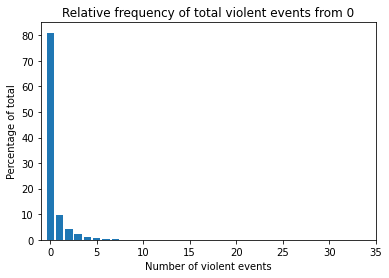

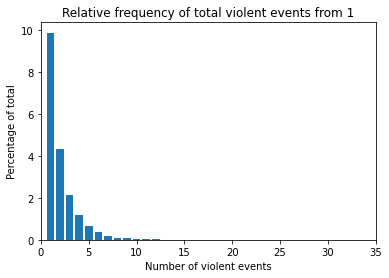

In [ ]:
import matplotlib.pyplot as plt
rel_freq = (data_base['tot_violent'].value_counts()/len(violence_vars))*100
plt.bar(rel_freq.index, rel_freq)
plt.xlim(left = -1, right=35)
plt.title('Relative frequency of total violent events from 0')
plt.xlabel('Number of violent events')
plt.ylabel('Percentage of total')
plt.show()

#rel_freq_top_10 = (rel_pareja_1['tot_violent'].value_counts()/len(violence_vars))*100
plt.bar(rel_freq.index[1:], rel_freq[1:])
plt.xlim(left = 0, right=35)
plt.title('Relative frequency of total violent events from 1')
plt.xlabel('Number of violent events')
plt.ylabel('Percentage of total')
plt.show()

We can see around 80% of women report no violent event with their partners. From the other 20%, most of them live between 1 and 5 violent events with their partner.

In [ ]:
#Reducing DF to those who have at least one violent event
rel_pareja_vio = data_base[data_base['tot_violent'] > 0].reset_index()

total_violent_events_3 = [0]*len(rel_pareja_vio)
total_violent_events_2 = [0]*len(rel_pareja_vio)
total_violent_events_1 = [0]*len(rel_pareja_vio)
#Esto no esta bien contado, deberia contar el mas alto para cada mujer creo
for col in violence_vars.columns:
    for i in rel_pareja_vio.index:
       # print('col is', col, 'i is', i)
        if rel_pareja_vio[col][i] == 1:  
            total_violent_events_1[i] += 1 
        elif rel_pareja_vio[col][i] == 2:  
            total_violent_events_2[i] += 1 
        elif rel_pareja_vio[col][i] == 3:  
            total_violent_events_3[i] += 1
            
rel_pareja_vio['many_times'] = total_violent_events_1   
rel_pareja_vio['few_times'] = total_violent_events_2
rel_pareja_vio['one_times'] = total_violent_events_3  

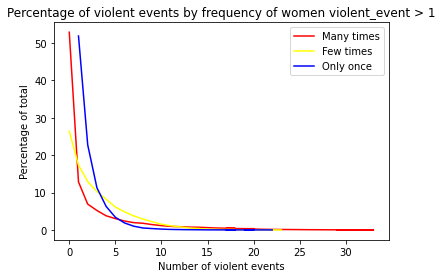

In [ ]:
freq_violence = pd.DataFrame()
freq_violence['many_times'] = (rel_pareja_vio['many_times'].value_counts()/len(rel_pareja_vio))*100
freq_violence['few_times'] = (rel_pareja_vio['few_times'].value_counts()/len(rel_pareja_vio))*100
freq_violence['one_times'] = (rel_pareja_vio['one_times'].value_counts()/len(rel_pareja_vio))*100

plt.plot(freq_violence.index, freq_violence['many_times'], color='red', label='Many times')
plt.plot(freq_violence.index, freq_violence['few_times'], color='yellow', label='Few times')
plt.plot(freq_violence.index, freq_violence['one_times'], color='blue', label='Only once')
plt.title('Percentage of violent events by frequency of women violent_event > 1')
plt.xlabel('Number of violent events')
plt.ylabel('Percentage of total')
plt.legend()
plt.show()

We can see 